# TimeSeries Analysis

In this work, we will try to solve the Time-series ML problem on toy data using two approaches. Facebook Prophet model and classical SARIMA model. We will train both models, compute metrics, try box cox transformation, and by given metrics find out what model best suit this task

In [ ]:
!pip install python-dateutil statsmodels tqdm fbprophet

In [16]:
# import all useful models
import warnings
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook
from fbprophet import Prophet

import matplotlib.pyplot as plt
import requests
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot


%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

In [17]:
# with data from xlsx some problems occurred, so I've copied data to txt file
with open('data.txt') as f:
    lst = list(map(lambda x: float(x.strip()[:-1]), f.readlines()))
               
with open('time.txt') as f:
    date = list(map(lambda x: x.strip()[1:-2], f.readlines()))
    
values = pd.DataFrame(lst)
date = pd.DataFrame(date)
df = pd.concat([date, values], axis=1)
df.columns = ['date', 'values']
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format = '%m/%d/%y %H:%M')
df.head()

,values
date,
2011-10-27 00:00:00,46686.61272
2011-10-27 01:00:00,46547.18699
2011-10-27 02:00:00,49645.21005
2011-10-27 03:00:00,53802.85310
2011-10-27 04:00:00,60335.85285


visualizing the data

In [18]:
init_notebook_mode(connected = True)


def plotly_df(df, column, title = ''):
    
    fig = go.Figure(go.Scatter(
        x = df.index,
        y = df[column],
        mode = 'lines',
        name = column
    ))

    fig.show()

In [19]:
plotly_df(df, 'values')

## Facebook Prophet model

We estimate perfomance of the prophet model on our data. Compute MAE, MAPE errors. Then we will give a shot to boxcox transformation and see whether it can improve perfomance or not.

In [23]:
df

,values
date,
2011-10-27 00:00:00,46686.61272
2011-10-27 01:00:00,46547.18699
2011-10-27 02:00:00,49645.21005
2011-10-27 03:00:00,53802.85310
2011-10-27 04:00:00,60335.85285
...,...
2011-11-04 02:00:00,34603.27048
2011-11-04 03:00:00,39479.04463
2011-11-04 04:00:00,48444.31587


In [22]:
df = df.reset_index()
df.columns = ['ds', 'y']
predition = int(0.2*df['ds'].shape[0])
train_df = df[:-predition].copy()
val_df = df[-predition:].copy()
train_df

,ds,y
0,2011-10-27 00:00:00,46686.61272
1,2011-10-27 01:00:00,46547.18699
2,2011-10-27 02:00:00,49645.21005
3,2011-10-27 03:00:00,53802.85310
4,2011-10-27 04:00:00,60335.85285
...,...,...
155,2011-11-02 11:00:00,55717.55846
156,2011-11-02 12:00:00,59158.74440
157,2011-11-02 13:00:00,56655.67974
158,2011-11-02 14:00:00,59291.68839


In [25]:
fbp = Prophet()
fbp.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [26]:
forecast = fbp.predict(val_df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
34,2011-11-04 02:00:00,40869.555871,25895.038403,33623.014118,40161.829395,41540.488470,-11306.967284,-11306.967284,-11306.967284,-11306.967284,-11306.967284,-11306.967284,0.0,0.0,0.0,29562.588588
35,2011-11-04 03:00:00,40683.671390,29774.688052,37310.687169,39944.471479,41391.467277,-7268.025253,-7268.025253,-7268.025253,-7268.025253,-7268.025253,-7268.025253,0.0,0.0,0.0,33415.646136
36,2011-11-04 04:00:00,40497.786908,33327.546514,40577.378862,39726.075247,41246.345498,-3479.319785,-3479.319785,-3479.319785,-3479.319785,-3479.319785,-3479.319785,0.0,0.0,0.0,37018.467123
37,2011-11-04 05:00:00,40311.902426,35516.736781,42692.133773,39507.240312,41075.889047,-1394.609908,-1394.609908,-1394.609908,-1394.609908,-1394.609908,-1394.609908,0.0,0.0,0.0,38917.292518
38,2011-11-04 06:00:00,40126.017945,35041.172908,42035.013061,39289.160464,40931.937487,-1585.417416,-1585.417416,-1585.417416,-1585.417416,-1585.417416,-1585.417416,0.0,0.0,0.0,38540.600529


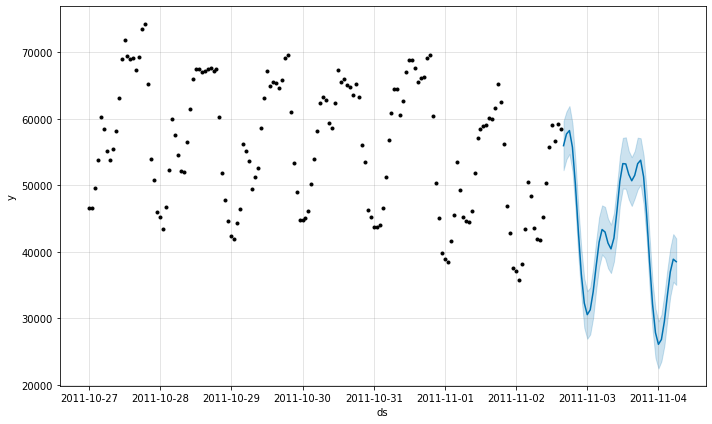

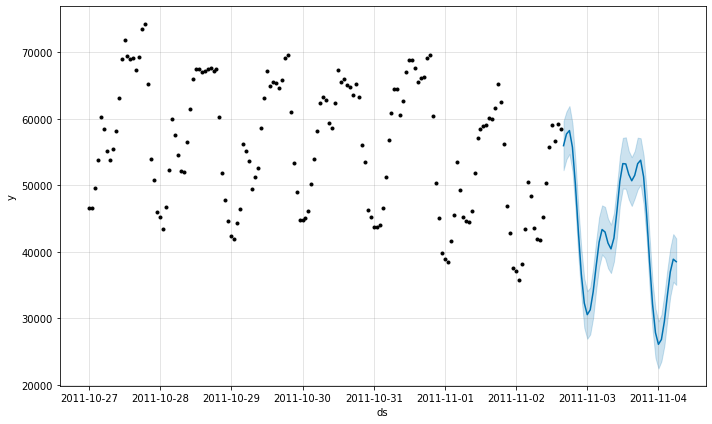

In [27]:
fbp.plot(forecast)

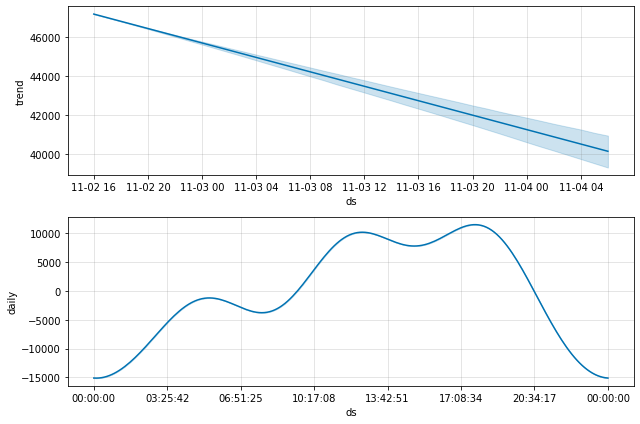

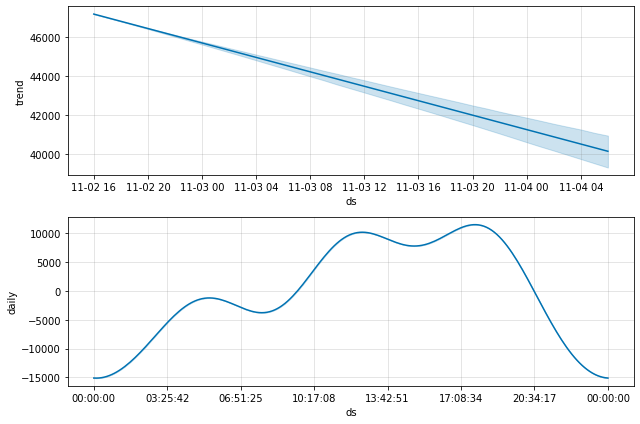

In [28]:
fbp.plot_components(forecast)

In [29]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df.tail()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2011-11-04 02:00:00,29562.588588,25895.038403,33623.014118,34603.27048
2011-11-04 03:00:00,33415.646136,29774.688052,37310.687169,39479.04463
2011-11-04 04:00:00,37018.467123,33327.546514,40577.378862,48444.31587
2011-11-04 05:00:00,38917.292518,35516.736781,42692.133773,45716.93987
2011-11-04 06:00:00,38540.600529,35041.172908,42035.013061,43158.63430


In [30]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predition:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predition:]['e'])), 2))

MAPE =  9.84
MAE =  4468.78


## BoxCox transformation

Let's see how box cox transformation will influence our data

In [31]:
def invboxcox(y, lmbda):
    # Inverser boxcox transformation
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

In [32]:
fbp2 = Prophet()
train_df_cox = train_df.copy()

train_df_cox.y, lmbda_train = scs.boxcox(
    train_df_cox.y
)

fbp2.fit(train_df_cox)
forecast2 = fbp2.predict(val_df)

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = invboxcox(forecast2[column], lmbda_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [34]:
cmp_df = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predition:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predition:]['e'])), 2))

MAPE =  10.27
MAE =  4444.0


As we can see, Mape got higher, whereas MAE improved a little bit. Nevertheless, we can conclude, that Box Cox transformation doesn't give benefits comparing with baseline

## SARIMA model

Now, we look at how SARIMA model will work with our data. First, we estimate the stationary of the data, perform data transformation to make it stationary and fit the SARIMA model. We also compute MAE, MAPE, and MSE error, perform and compare it with the Prophet 

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title("Time Series Analysis Plots")
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Dickey-Fuller test: p=0.000047
Optimal Box-Cox transformation parameter: 1.415604


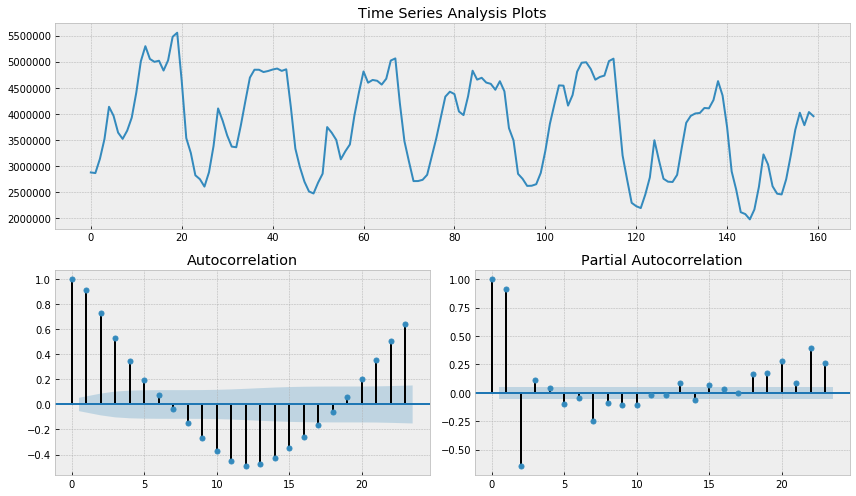

In [24]:
data = train_df.copy()
data["values_box"], lmbda = scs.boxcox(
    data.y
)
tsplot(data.values_box)
print("Optimal Box-Cox transformation parameter: %f" % lmbda)

Dickey-Fuller test: p=0.000000


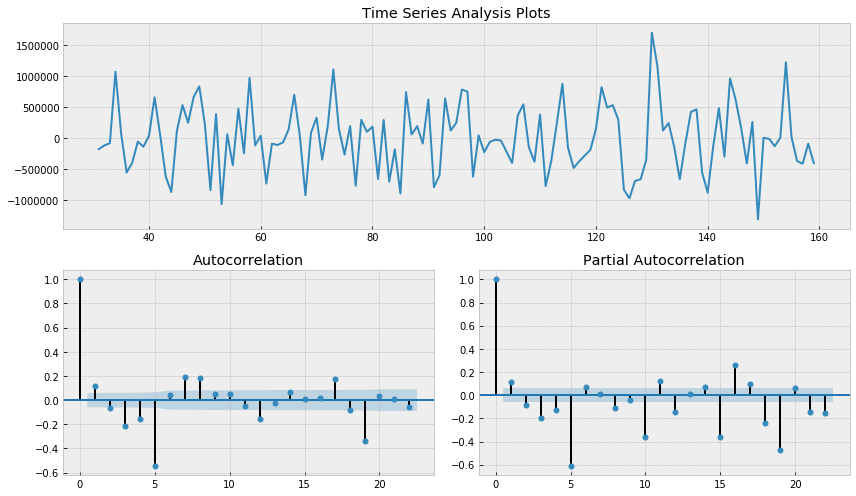

In [39]:
data["values_box_shifted"] = data.values_box - data.values_box.shift(25)
data["values_box_shifted"] = data.values_box_shifted - data.values_box_shifted.shift(5)
data["values_box_shifted"] = data.values_box_shifted - data.values_box_shifted.shift(1)

tsplot(data["values_box_shifted"].dropna())

In [65]:
d = 2
D = 2
ps = range(0, 5)
qs = range(0, 4)
Ps = range(0, 5)
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [75]:
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    # try except is needed because the model is not trained on some parameter sets
    try:
        model = sm.tsa.statespace.SARIMAX(
            data.values_box,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 24),
        ).fit(disp=-1)
    # we display the parameters on which the model is not trained and go to the next set
    except ValueError:
        # print('wrong parameters:', param)
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings("default")

result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
83  (4, 0, 3, 0)  3702.302086
84  (4, 0, 4, 0)  3702.320280
74  (3, 2, 4, 0)  3703.042596
73  (3, 2, 3, 0)  3703.343457
54  (2, 2, 4, 0)  3703.758196


In [77]:
best_model = sm.tsa.statespace.SARIMAX(
    data.values_box, order=(4, d, 0), seasonal_order=(3, D, 0, 24)
).fit(disp=-1)
best_model.summary()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         values_box   No. Observations:                  160
Model:             SARIMAX(4, 1, 0)x(3, 1, 0, 24)   Log Likelihood               -1843.151
Date:                            Sat, 13 Mar 2021   AIC                           3702.302
Time:                                    14:45:01   BIC                           3725.544
Sample:                                         0   HQIC                          3711.747
                                            - 160                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0760      0.078      0.976      0.329      -0.077       0.229
ar.L2          0.0438      0.102      0.430      0.667      -0.156       0.244
ar.L3         -0.1669      0.082     -2.042      0.041      -0.327      -0.007
ar.L4         -0.1025      0.117     -0.876      0.381      -0.332       0.127
ar.S.L24      -0.3191      0.061     -5.205      0.000      -0.439      -0.199
ar.S.L48      -0.2707      0.054     -4.995      0.000      -0.377      -0.164
ar.S.L72      -0.1705      0.030     -5.616      0.000      -0.230      -0.111
sigma2      5.088e+10   3.15e-13   1.62e+23      0.000    5.09e+10    5.09e+10
===================================================================================
Ljung-Box (Q):                       43.27   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.33   Prob(JB):                         0.07
Heteroskedasticity (H):               1.47   Skew:                            -0.29
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.96e+38. Standard errors may be unstable.
"""

Критерий Дики-Фуллера: p=0.000000


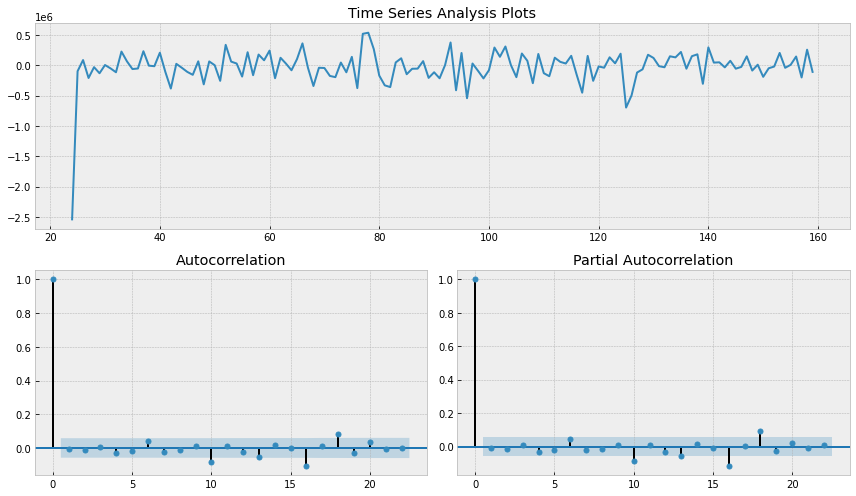

In [78]:
tsplot(best_model.resid[24:].dropna())

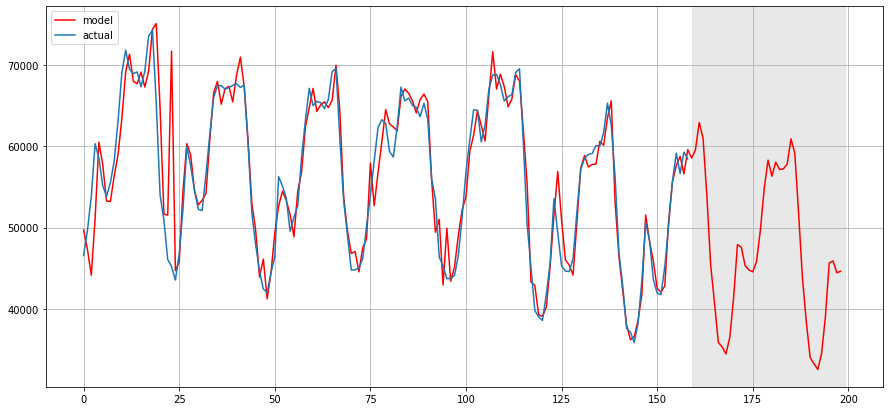

In [79]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(
    best_model.predict(start=data.shape[0], end=data.shape[0] + 39), lmbda
)
forecast = data.arima_model.append(forecast).values[1:]
actual = data.y.values[1:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color="r", label="model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color="lightgrey")
plt.grid(True)


In [81]:
e = val_df.y.values - data.arima_model[-39:].values
p = 100 * e / val_df.y
print('MAPE = ', round(np.mean(abs(p)), 2))
print('MAE = ', round(np.mean(abs(e)), 2))

MAPE =  28.31
MAE =  12879.9


As we see in comparison with Prophet model, SARIMA tends to overfit more and has higher errors than the Prophet. 